Loading dataset...
Extracting features using parallel processing...
Found classes: ['Tshirt', 'cap', 'loafers', 'pant', 'sandals', 'shirt', 'shorts']
Class distribution before balancing: Counter({'sandals': 237, 'loafers': 187, 'Tshirt': 129, 'shirt': 106, 'shorts': 67, 'pant': 61, 'cap': 3})
Training classifier with optimized settings...
Evaluating classifier...
Test Accuracy: 89.46%
Classification Report:
              precision    recall  f1-score   support

      Tshirt       0.92      0.94      0.93        47
         cap       1.00      1.00      1.00        47
     loafers       0.73      0.77      0.75        47
        pant       0.98      1.00      0.99        48
     sandals       0.74      0.60      0.67        48
       shirt       0.94      0.96      0.95        47
      shorts       0.92      1.00      0.96        48

    accuracy                           0.89       332
   macro avg       0.89      0.89      0.89       332
weighted avg       0.89      0.89      0.89    

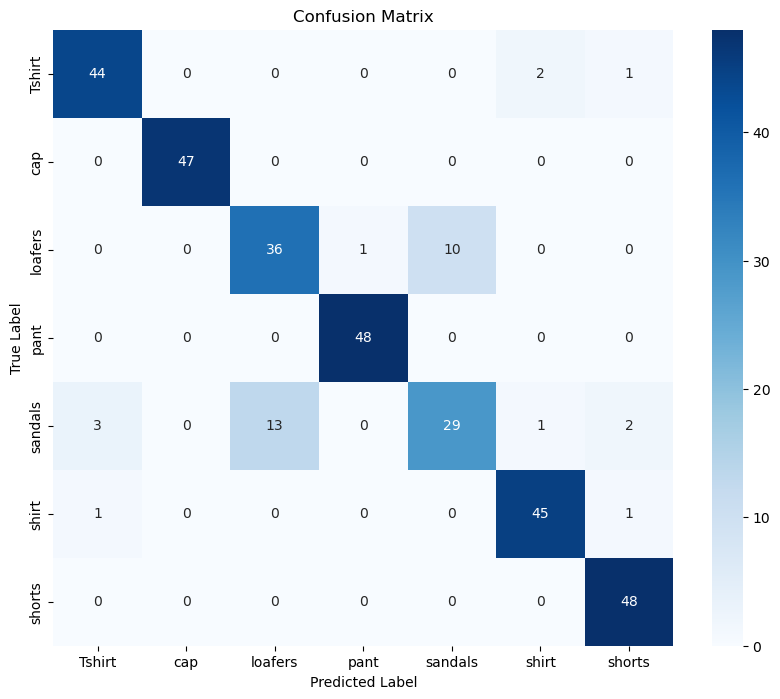

Model saved as clothing_classifier.pkl


In [1]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # Faster image loading
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import Parallel, delayed
from collections import Counter
from imblearn.over_sampling import RandomOverSampler  # For dataset balancing

# Parameters
dataset_dir = r"C:\Games\dataset"  # Change to your dataset path
image_size = (128, 128)
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
feature_path = "hog_features.pkl"
model_path = "clothing_classifier.pkl"

def process_image(file_path, label):
    """Loads an image, extracts HOG features, and returns (features, label)."""
    try:
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        if image is None:
            print(f"Warning: Skipping {file_path}, could not load.")
            return None
        image_resized = cv2.resize(image, image_size)  # Resize for consistency
        feature_vector = hog(
            image_resized,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=False,
            feature_vector=True
        )
        return feature_vector, label
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset_parallel(dataset_dir):
    """Loads dataset using parallel processing. If preprocessed features exist, loads from file."""
    if os.path.exists(feature_path):
        print("Loading preprocessed features from disk...")
        return joblib.load(feature_path)
    
    print("Extracting features using parallel processing...")
    features_labels = []
    
    # Get class names (folders) and ensure they are directories
    class_names = sorted([f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))])
    print(f"Found classes: {class_names}")

    for label in class_names:
        class_dir = os.path.join(dataset_dir, label)
        if not os.path.isdir(class_dir):
            continue
        
        # Filter for image files only
        file_paths = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                      if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Parallel processing for feature extraction
        results = Parallel(n_jobs=-1, backend="loky")(
            delayed(process_image)(file_path, label) for file_path in file_paths
        )

        # Remove failed extractions
        features_labels.extend([res for res in results if res])

    if not features_labels:
        print("Error: No images were successfully processed.")
        return np.array([]), np.array([]), []

    features, labels = zip(*features_labels)
    features, labels = np.array(features), np.array(labels)

    # Save extracted features for faster future runs
    joblib.dump((features, labels, class_names), feature_path)
    return features, labels, class_names

# Remove old cached features if dataset changes
if os.path.exists(feature_path):
    os.remove(feature_path)

# Load dataset
print("Loading dataset...")
X, y, class_names = load_dataset_parallel(dataset_dir)

if len(X) == 0 or len(y) == 0:
    print("Error: No images found in the dataset.")
    exit()

# Check dataset distribution before splitting
print("Class distribution before balancing:", Counter(y))

# Balance dataset using oversampling (fixes missing classes)
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features for faster SVM training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM classifier
print("Training classifier with optimized settings...")
classifier = SVC(kernel="linear", cache_size=1000, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate classifier
print("Evaluating classifier...")
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save model
joblib.dump((classifier, scaler, class_names), model_path)
print(f"Model saved as {model_path}")


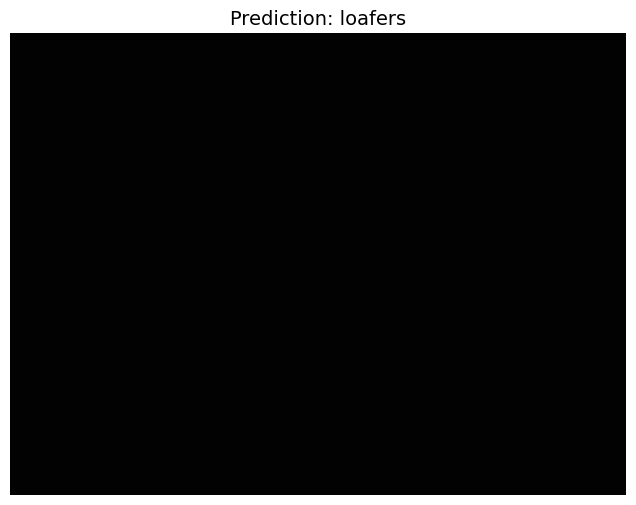

Camera released.


In [7]:
import joblib
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from skimage import color, transform
from skimage.feature import hog

# Parameters
image_size = (128, 128)
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
model_path = "clothing_classifier.pkl"

# Load trained model
print("Loading trained model...")
classifier, scaler, class_names = joblib.load(model_path)  # ✅ Corrected

def live_camera_classification(classifier, class_names, duration=30):
    """Classify real-time webcam frames."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    plt.figure(figsize=(8, 6))
    start_time = time.time()

    try:
        while (time.time() - start_time) < duration:
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess frame (same as training pipeline)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)

            # Extract HOG features
            feature_vector = hog(
                resized,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=False,
                feature_vector=True
            )

            # Predict
            prediction = classifier.predict([feature_vector])[0]

            # Display in Jupyter
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Prediction: {prediction}", fontsize=14)
            plt.axis('off')
            clear_output(wait=True)  # Clear previous output
            display(plt.gcf())       # Show current frame

            time.sleep(0.1)  # Reduce CPU load

    finally:
        cap.release()
        plt.close()
        print("Camera released.")

# Start live camera classification
print("\nStarting live camera classification for 30 seconds...")
live_camera_classification(classifier, class_names, duration=30)
